# Regression Model on Attended Features.ipynb

---

* Table of contents
  * Creating the environment
  * Preprocessing the data
  * Preparing the data
  * Training the model
  * Evaluating the performance measure
  * Performing OCR within bounding box

* Resources ~ 
  * https://github.com/Cyanogenoid/pytorch-vqa
  * https://github.com/Cyanogenoid/vqa-counting/tree/master/vqa-v2

### Creating the environment
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Upgrade pillow to latest version to resolve an attribute issue when importing model
! pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os, sys
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)

#### Download the Prebuilt VQA model and Weights

In [ ]:
if not os.path.isfile('./pytorch-vqa/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-vqa.git
sys.path.append(os.path.realpath('./pytorch-vqa'))

#### Accelerating with CUDA

In [ ]:
try: 
    import torch
except:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
    !pip install -q \
      http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl \
      torchvision

In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
import importlib.util

MODULE_PATH = "/content/pytorch-vqa/model.py"
MODULE_NAME = "model"

spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(model)
saved_state = torch.load('/content/drive/MyDrive/DVQA/SAN-DVQA/2022-06-23_13:00:45.pth', map_location=device)
tokens = len(saved_state['vocab']['question']) + 1
saved_state.keys()

dict_keys(['name', 'tracker', 'config', 'weights', 'eval', 'vocab'])

In [ ]:
# Loading the model with weights
vqa_net = torch.nn.DataParallel(model.Net(tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(1126, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=27, bias=True)
    )
  )
)

In [ ]:
if not os.path.isfile('./pytorch-resnet/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-resnet.git
sys.path.append(os.path.realpath('./pytorch-resnet'))

Cloning into 'pytorch-resnet'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


In [ ]:
import importlib.util

MODULE_PATH = "/content/pytorch-vqa/resnet/resnet.py"
MODULE_NAME = "resnet"

spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
resnet = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet)

from PIL import Image
import torchvision.transforms as transforms

def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super(ResNetLayer4, self).__init__()
        self.model = resnet.resnet152(pretrained=True)
        
        # from  visual_qa_analysis/config.py
        image_size = 384  # scale shorter end of image to this size and centre crop
        #output_size = image_size // 32  # size of the feature maps after processing through a network
        output_features = 2048  # number of feature maps thereof
        central_fraction = 0.875 # only take this much of the centre when scaling and centre cropping

        self.transform = get_transform(image_size, central_fraction)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer
    
    def image_to_features(self, img_file):
        img = Image.open(img_file).convert('RGB')
        img_transformed = self.transform(img)
        #print(img_transformed.size())
        img_batch = img_transformed.unsqueeze(0).to(device)
        return self.forward(img_batch) 
    
resnet_layer4 = ResNetLayer4().to(device)  # Downloads 241Mb model when first run

Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /root/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

> Taking a look at the vocab of the model ~

In [ ]:
vocab = saved_state['vocab']
vocab.keys()  # dict_keys(['question', 'answer'])
list(vocab['question'].items())[:5]

[('the', 1), ('in', 2), ('of', 3), ('is', 4), ('how', 5)]

In [ ]:
qtoken_to_index = vocab['question']
QUESTION_LENGTH_MAX = 30 # say...
    
def encode_question(question_str):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question_str.lower().split(' ')
    #vec = torch.zeros(QUESTION_LENGTH_MAX).long()
    vec = torch.zeros(len(question_arr)).long()  
    for i, token in enumerate(question_arr):
        vec[i] = qtoken_to_index.get(token, 0)
    return vec.to(device), torch.tensor( len(question_arr) ).to(device)

In [ ]:
list(vocab['answer'].items())[:5]

[('e', 0), ('o', 1), ('n', 2), ('s', 3), ('y', 4)]

In [ ]:
answer_words = ['UNDEF'] * len(vocab['answer'])
for w,idx in vocab['answer'].items():
    answer_words[idx]=w
len(answer_words), answer_words[:10]

(27, ['e', 'o', 'n', 's', 'y', '0', '1', 'r', '9', 't'])

### Preprocessing the data
---

In [ ]:
!mkdir images

In [ ]:
!unzip '/content/drive/MyDrive/DVQA/images/train.zip' -d '/content/images'
!unzip '/content/drive/MyDrive/DVQA/images/val.zip' -d '/content/images'
!unzip '/content/drive/MyDrive/DVQA/images/test.zip' -d '/content/images'

#### For train

In [ ]:
import json
import pandas as pd

json_file_path = "/content/drive/MyDrive/DVQA/question-answer/qa_ocr/train.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dft = pd.DataFrame(contents)

In [ ]:
def AttendedFeatures(row):
    img = '/content/images/train/' + row['image']
    feature_image = resnet_layer4.image_to_features(img)
    ques, ques_len = encode_question(row['question'])
    ans = vqa_net(feature_image, ques.unsqueeze(0), ques_len.unsqueeze(0))
    return (ans.cpu().detach().numpy())
train_attended = dft.assign(attended_features=dft.apply(AttendedFeatures, axis=1))
train_attended.head()

In [ ]:
out = train_attended.to_json(orient = 'records')
with open('/content/drive/MyDrive/DVQA/question-answer/qa_attended_features/train.json', 'w') as f:
  f.write(out)

#### For validation

In [ ]:
import json
import pandas as pd

json_file_path = "/content/drive/MyDrive/DVQA/question-answer/qa_ocr/val.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dft = pd.DataFrame(contents)

In [ ]:
def AttendedFeatures(row):
    img = '/content/images/val/' + row['image']
    feature_image = resnet_layer4.image_to_features(img)
    ques, ques_len = encode_question(row['question'])
    ans = vqa_net(feature_image, ques.unsqueeze(0), ques_len.unsqueeze(0))
    return (ans.cpu().detach().numpy())
val_attended = dft.assign(attended_features=dft.apply(AttendedFeatures, axis=1))
val_attended.head()

In [ ]:
out = val_attended.to_json(orient = 'records')
with open('/content/drive/MyDrive/DVQA/question-answer/qa_attended_features/val.json', 'w') as f:
  f.write(out)

#### For test

In [ ]:
import json
import pandas as pd

json_file_path = "/content/drive/MyDrive/DVQA/question-answer/qa_ocr/test.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dft = pd.DataFrame(contents)

In [ ]:
def AttendedFeatures(row):
    img = '/content/images/test/' + row['image']
    feature_image = resnet_layer4.image_to_features(img)
    ques, ques_len = encode_question(row['question'])
    ans = vqa_net(feature_image, ques.unsqueeze(0), ques_len.unsqueeze(0))
    return (ans.cpu().detach().numpy())
test_attended = dft.assign(attended_features=dft.apply(AttendedFeatures, axis=1))
test_attended.head()

In [ ]:
out = test_attended.to_json(orient = 'records')
with open('/content/drive/MyDrive/DVQA/question-answer/qa_attended_features/train_2.json', 'w') as f:
  f.write(out)

### Preparing the data
---

#### For train

In [ ]:
import json
import pandas as pd

json_file_path = "/content/drive/MyDrive/DVQA/question-answer/qa_attended_features/train.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dtrain = pd.DataFrame(contents)

In [ ]:
import numpy as np
X_train = dtrain['attended_features'].str[0]
train = []
for i in X_train:
  train.append(i)
X_train = np.array(train)

In [ ]:
X_train

array([[ -35.17118835,  -31.35714531,  -44.58410263, ..., -207.15794373,
        -232.7442627 , -244.66621399],
       [ -29.77085304,  -26.38825798,  -42.14429855, ..., -167.30506897,
        -146.85246277, -192.06391907],
       [ -51.05919266,  -51.72984314,  -54.31179428, ...,  -94.12476349,
         -60.68599701, -102.42050171],
       ...,
       [ -59.36830902,  -60.53302383,  -63.84210587, ..., -112.26236725,
         -87.91725922, -125.79407501],
       [ -45.00176239,  -44.70238113,  -47.18650818, ...,  -93.59251404,
         -81.71409607, -104.35671997],
       [ -28.09696007,  -20.2185688 ,  -29.90560341, ..., -143.83818054,
        -188.14109802, -163.7539978 ]])

In [ ]:
y_train = dtrain['answer_bbox']
train = []
for i in y_train:
  train.append(i)
y_train = np.array(train)

#### For validation

In [ ]:
import json
import pandas as pd

json_file_path = "/content/drive/MyDrive/DVQA/question-answer/qa_attended_features/val.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dval = pd.DataFrame(contents)

In [ ]:
X_val = dval['attended_features'].str[0]
val = []
for i in X_val:
  val.append(i)
X_val = np.array(val)

In [ ]:
X_val

array([[ -37.48696899,  -37.75655746,  -40.20143509, ...,  -73.65563965,
         -79.48516083,  -86.87966156],
       [ -39.33940506,  -40.57651901,  -43.98202515, ...,  -74.1279068 ,
         -79.26383209,  -87.80954742],
       [ -35.8677597 ,  -37.50686264,  -49.40447235, ..., -127.8442688 ,
        -157.21913147, -156.78884888],
       ...,
       [ -61.66205597,  -62.91182709,  -66.85939026, ..., -123.88307953,
        -107.05649567, -140.29397583],
       [ -44.30028534,  -44.18427658,  -46.52615738, ...,  -91.38368225,
         -82.44355774, -102.36474609],
       [ -24.93727875,  -17.13492393,  -27.56616974, ..., -128.75292969,
        -184.42388916, -149.35096741]])

In [ ]:
y_val = dval['answer_bbox']
val = []
for i in y_val:
  val.append(i)
y_val = np.array(val)

#### For test

In [ ]:
import json
import pandas as pd

json_file_path = "/content/drive/MyDrive/DVQA/question-answer/qa_attended_features/test.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dtest = pd.DataFrame(contents)

In [ ]:
X_test = dtest['attended_features'].str[0]
test = []
for i in X_test:
  test.append(i)
X_test = np.array(test)

In [ ]:
X_test

array([[ -36.92976761,  -37.24534225,  -39.52371979, ...,  -71.08641815,
         -73.89104462,  -83.12647247],
       [ -35.62318039,  -37.64751816,  -50.90515518, ..., -132.98548889,
        -163.05259705, -160.03053284],
       [ -36.35834122,  -37.12150955,  -49.26860428, ..., -137.03108215,
        -161.66175842, -164.15557861],
       ...,
       [ -63.05939102,  -64.07436371,  -68.45293427, ..., -126.33996582,
        -106.1464386 , -140.50883484],
       [ -41.05303574,  -40.32219315,  -42.59866714, ...,  -83.609375  ,
         -82.36370087,  -94.25128937],
       [ -23.66281319,  -17.68763733,  -26.33063698, ..., -118.27907562,
        -165.71388245, -137.55984497]])

In [ ]:
y_test = dtest['answer_bbox']
test = []
for i in y_test:
  test.append(i)
y_test = np.array(test)

### Training the model 
---

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, LeakyReLU

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=X_test.shape[1], kernel_initializer='he_uniform', activation=LeakyReLU(alpha=0.01)))
model.add(Dense(64))
model.add(Dense(4))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3584      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 12,100
Trainable params: 12,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=32,epochs=100)

In [ ]:
model.save_weights('regression_model.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/DVQA/Regression Model/regression_model.h5')

### Evaluating the performance measure
---

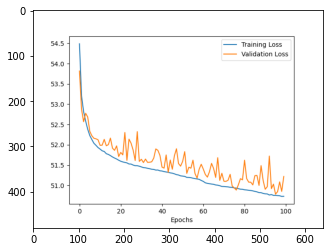

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/DVQA/Regression Model/Performance Measure.png').convert('RGB')
plt.imshow(img)

In [ ]:
mae = model.evaluate(X_test, y_test, verbose=0)
print('>%.3f' % mae)

>6950.065


### Performing OCR within bounding box
---

In [ ]:
### Sample Number
num = 13

In [ ]:
test = X_test[num]
test = np.resize(test, (1,27))
test

array([[ -32.80073166,  -27.63332558,  -45.28879166,  -77.01376343,
         -80.78464508, -111.99349213,  -70.9388504 ,  -62.04734039,
         -76.81391144,  -69.27565765,  -79.00993347,  -73.12581635,
         -74.28811646,  -86.06430054,  -79.31897736,  -78.90366364,
         -93.80573273,  -82.33982086,  -80.85629272, -104.16552734,
         -77.44907379,  -89.21320343, -101.69580841,  -94.43715668,
        -177.95150757, -164.62767029, -205.83683777]])

In [ ]:
actual = y_test[num]
actual

array([ 69.05597643, 402.2       ,  86.25      ,  39.        ])

In [ ]:
pred = model.predict(test)
pred

array([[118.13475 , 414.3667  ,  61.2319  ,  37.562958]], dtype=float32)

In [ ]:
dtest['question'][num]

'Which bar has the smallest value?'

Text(0.5, 1.0, 'Question:  Which bar has the smallest value?')

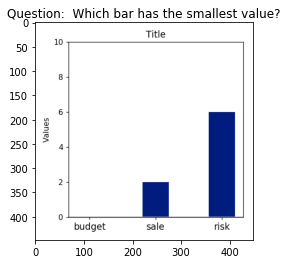

In [ ]:
image = Image.open('/content/images/test/' + str(dtest['image'][num])).convert('RGB')
plt.imshow(image)
plt.title('Question:  ' + dtest['question'][num])

In [ ]:
import cv2
filename = '/content/images/test/' + str(dtest['image'][num])
image = cv2.imread(filename)

In [ ]:
(X, Y, W, H) = (int(actual[0]), int(actual[1]), int(actual[2]),  int(actual[3]))
actual_box = image[Y:Y+H, X:X+W]

In [ ]:
(X, Y, W, H) = (int(pred[0][0]), int(pred[0][1]), int(pred[0][2]),  int(pred[0][3]))

bounding_box = image[Y:Y+H, X:X+W]

Text(0.5, 1.0, 'Actual Answer')

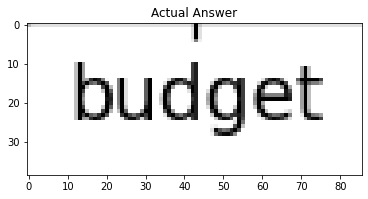

In [ ]:
plt.imshow(actual_box)
plt.title('Actual Answer')

Text(0.5, 1.0, 'Predicted Answer')

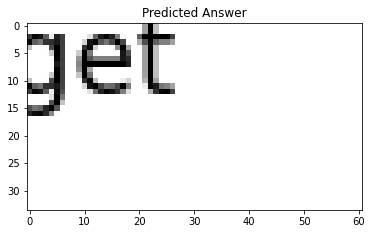

In [ ]:
plt.imshow(bounding_box)
plt.title('Predicted Answer')

#### Using OCR Pytesseract

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
import pytesseract
extractedInformation = pytesseract.image_to_string(bounding_box)
print(extractedInformation)

get

